<a href="https://colab.research.google.com/github/ikonushok/AI-Traiding/blob/main/%D0%9F%D1%80%D0%B8%D0%BC%D0%B5%D1%80_%D0%BF%D1%80%D0%B8%D0%BC%D0%B5%D0%BD%D0%B5%D0%BD%D0%B8%D1%8F_RL_%D1%81_%D0%BD%D1%83%D0%BB%D1%8F__%D0%B2_%D1%84%D0%B8%D0%BD%D1%82%D0%B5%D1%85%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import random
import torch
from matplotlib import pyplot as plt
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import plotly
import plotly.graph_objs as go

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [ ]:
def set_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_random_seed(42)

When we come across numerical series, the question immediately arises about their stationarity (we'll talk about this in a separate article). When the numerical series is stationary (it has constant mean, variance and no trend), but the problem is easily solved by classical machine learning (ML) methods.

If the numerical series is unstable, for example, the stock price, then difficulties arise in forecasting or classifying it. Such research is costly and requires a specific approach to neural network training to be successful.

And here `Reinforcement Learning` comes to our aid, which is especially useful when the problem can be set as an Markov decision process (MDP), and foreshadows good results when the `Environment` or `Reward` is non-stationary, i.e. it changes significantly over time.



# About Reinforcement Learning

As you may already know, the main two parts of a reinforcement learning system are:

**Environment** is a "playing field" or in our case, a market that can tell us what is happening right now and what our reward will be in the future if we take some action right now. What the `Agent` interacts with.

**Agent (Agent)** — A "player" who interacts with the environment and learns to maximize long-term reward by performing various actions in different situations. Selects actions based on what is known about the `Environment` from the collected data and policies.

**Action** - Various options for actions that the `Agent` can choose at any given time.

**State** - The agent's current situation.

**Reward** - feedback from the `Environment` that the agent needs to find out if an `Action` has been taken a good one.

**Policy** - The process of choosing actions based on known information about the environment.

**Value** - the future reward that the agent will receive by performing an action in a certain state.

Graphically, this can be represented in the following diagram:


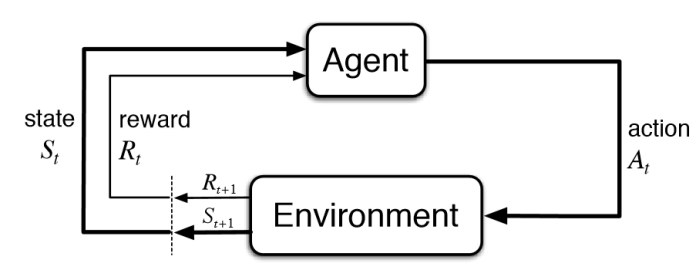
<center>Иллюстрация с https://www.kdnuggets.com/2018/03/5-things-reinforcement-learning.html<center>


Let's also mention the **Markov Decision Process (MDP)**. is a sequence of time steps in which interaction with the environment takes place.

At each point in time, the current state is used to perform an action step, after which the environment provides feedback in the form of a reward about this step and the new state.

# Environment

If the states are complex and difficult to represent in the form of an action table, they can be approximated using a neural network (this is what we will do).

With the help of a neural network, we can choose the most profitable action in each state (according to our `Q` function) and maximize the reward.

But how to build such a `Q` function? Here we will be helped by the `Q-Learning` algorithm, which will be based on the famous `Bellman equation`:




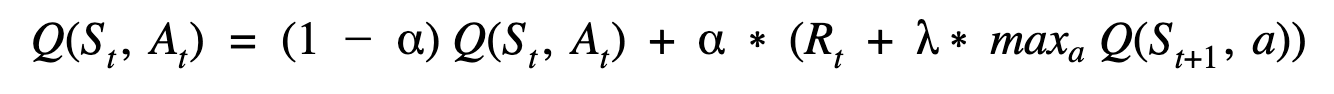

<center>Иллюстрация с https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc<center>

**S** = Status or observation

**A** = The action that the agent is taking

**R** = Reward for action

**t** = Time step

**$\alpha$** = Learning rate

**$\lambda$** = Discount factor, due to which rewards lose their value over time, so more immediate rewards are valued higher.


A little bit about **Discounting**:

In RL, an agent strives for an optimal policy, a set of steps that lead to a trajectory (strategy) that provides the greatest reward.

This is achieved by evaluating the direct reward for each next step plus evaluating the reward for all future steps when performing this action.

When it is a continuous task, calculating all future rewards is impossible, and estimating rewards for a large number of steps in the future is often fraught with uncertainty.

Thus, `Discounting` ensures that more weight is given to expected rewards in the near future, and less weight is given to more uncertain rewards in the distant future.

# Implementation of Reinforcement Learning

You can often hear arguments that one or another RL algorithm is better than another. At the same time, each of the "authoritative parties" forgets that the choice of algorithm depends on how much the environment itself or its change can be "calculated", as well as whether the change of the environment itself depends on the actions of the agent.

**One of the most important branching points in the RL algorithm is the question of whether the agent has access to (or is studying) the environment model.**

By the environment model, we mean a function that predicts state transitions and rewards.

Algorithms using the model are called model-based methods, and those that do not use the model are called model-free methods.

While model-free methods forgo the potential to improve sampling efficiency by using a model, they are generally easier to implement and configure.



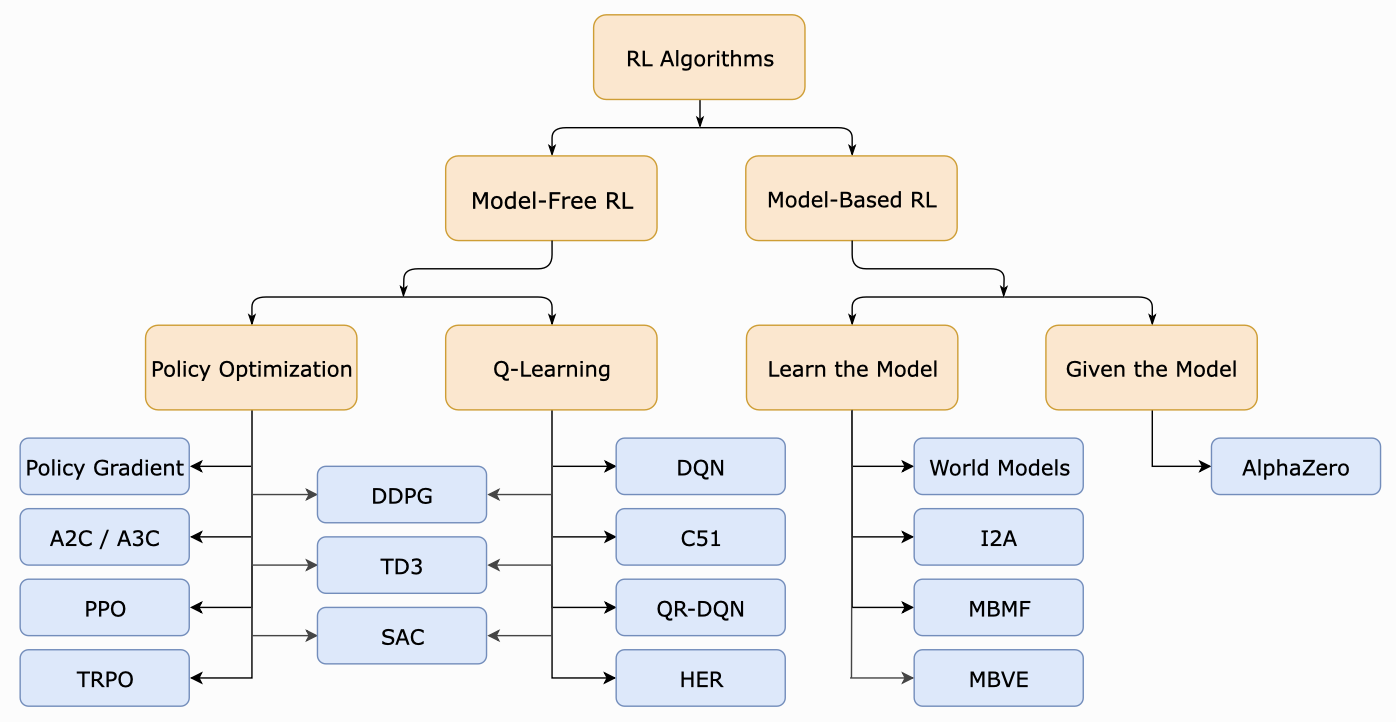

<center>Иллюстрация с https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html#citations-below<center>



# Deep Q-Learning:


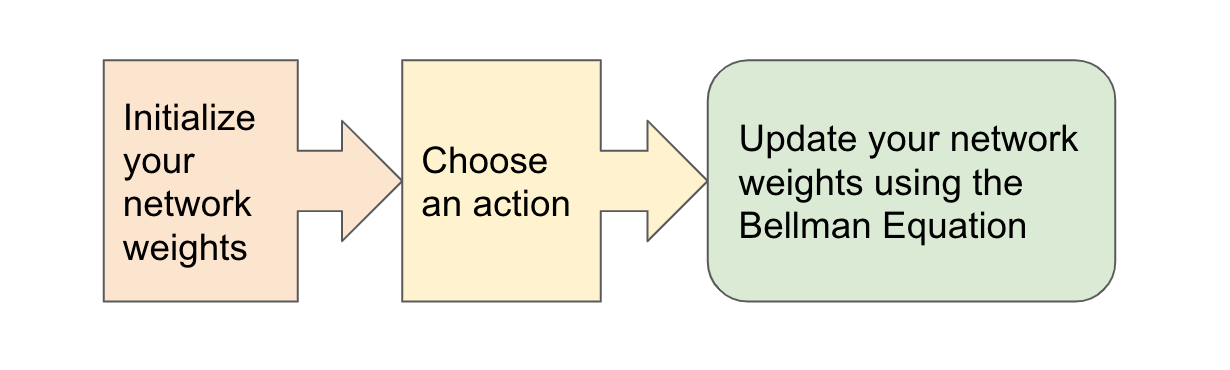

<center>Иллюстрация с https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc<center>

In [ ]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет
        происходить дальнейшее обучение
    '''
    def __init__(self, length = 100, normalize = True, noise = True, data = []):
        self.length = length

        if len(data) == 0:
            # Если данные не поданы, формируем их сами
            # на основе синуса размером length
            self.data = np.sin(np.arange(length) / 30.0)
        else:
            # Иначе подугружаем существующие
            self.data = np.array(data).flatten()


        if noise:
            # Подаем шум для данных от 0.1 до 1
            self.data += np.random.normal(0, 0.1, size = self.data.shape)

        if normalize:
            # Нормализация после данных после шума
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        Возвращаем производные отдельного окна в нашей выборке
        и убираем нули в начале
        """
        window = self.data[time-lookback:time]
        if diff: window = np.diff(window, prepend = window.flatten()[0])
        return window

    def get_reward(self, action, action_time, reward_time, coef = 100):
        """
        Основная логика получения награды
        0 => long 1 => hold 2 => short
        """
        if action == 0:
            action = -1
        # print(23, self.data)
        # Вытаскиваем текущую цену
        price_now = self.data[action_time]
        # Вытаскиваем следующую цену
        price_reward = self.data[reward_time]
        # Получаем разницу в проценте
        price_diff = (price_reward - price_now) / price_now
        # Прибавляем к портфелю следующее число:
        # Дельта изменения валюты * покупку/продажу/холд * коэф. закупки
        reward = np.sign(price_diff) * action * coef
        # print(12121, reward)
        return reward

## An example of creating a learning environment `Агента`

With the help of our code, we can create an Environment of different lengths and, if necessary, make it noisy, bringing it closer to real conditions:

In [ ]:
# Создадим тестовую среду
lin_env = Environment(normalize=True, noise=True)
# Отобразим все производные отдельного окна с 95 по 100 выборку
lin_env.get_state(100, 5, True)

array([ 0.        ,  0.11085544, -0.02855247, -0.04563675, -0.04426702])

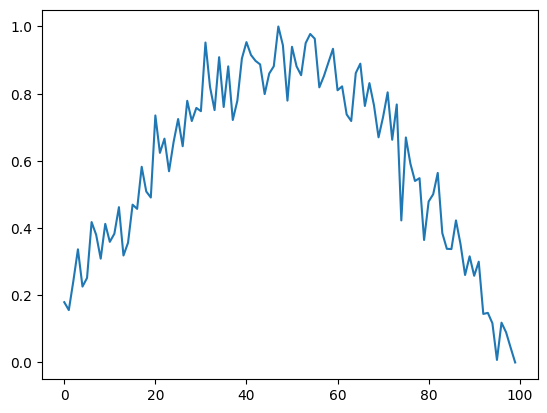

In [ ]:
# Отобразим сгенерированные данные внутри среды
plt.figure()
plt.plot(lin_env.data)
plt.show()

In [ ]:
print(f' Протяженность Среды: {-lin_env.get_reward(0, 50, 51)}')

 Протяженность Среды: -100.0



The implementation of the `Environment` and `Agent` classes is relatively simple, but I would like to outline the learning cycle again here:

The iteration takes place over `N` epochs, where each epoch is a common iteration environment.

For each sample in the medium, we:
1. We get the `current state` at time `t`
2. We will get a `value function` for all actions in this state (our neural network will give us 3 values)
3. Perform an `action' in this state (for example, act randomly, exploring)
4. We will receive a `reward` for this action from the environment (see class)
5. We will get the `next state` after the current one (for future long-term rewards)
6. `Save the tuple` of the current state, the next state, the value function and the reward for repeating the experience.
7. `Reproduce the experience` — we will adjust our neural network to some samples from the buffer of experience reproduction in order to make the `Q' function more adequate in relation to what rewards we receive for actions at this stage.

I recommend reading more [here](https://deeplizard.com/learn/video/Bcuj2fTH4_4 ) , but in a nutshell , it is better to train on uncorrelated mini-packages of data than on highly correlated step—by-step observations - this helps generalization and convergence.



## Agent

The architecture of our neural network will be very similar to a simple neural classification network with several classes (see Figure 4)

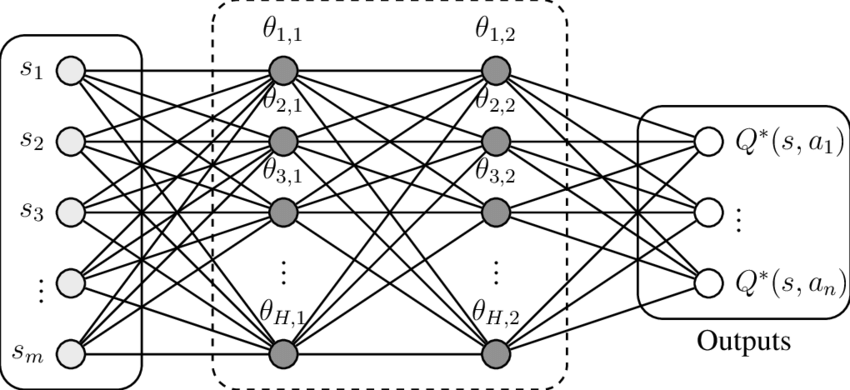

<center>Иллюстрация с https://medium.com/@vincentpeijnenburg/a-reinforcement-learning-approach-to-dynamic-pricing-in-an-airline-simulation-competition-8db537f2382f<center>

The functions that represent the state are on the left, then there are hidden layers with activation functions such as relu that allow for non-linear relationships and complex interactions, and on the right is the output layer.

However, instead of using the softmax function to convert the output data into a probability distribution, the output data will remain absolute values.

Figuratively speaking, it's actually more like setting up a regression with multiple outputs.


In [ ]:
import collections

In [ ]:
# Обратите внимание на то, что в RL часто используются совсем простые нейронные сети
class Net(nn.Module):
    """Строим простую модель нейронки"""
    def __init__(self, state_shape, action_shape):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(state_shape, 10)
        self.fc2 = nn.Linear(10, action_shape)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Создадим экземпляр модели с 10 входами, 3 выходами
# и отобразим ее
net = Net(10, 3)
net

Net(
  (fc1): Linear(in_features=10, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=3, bias=True)
)

In [ ]:
class BuyHoldSellAgent:
    '''
        Агент для покупки продажи
    '''
    def __init__(self, state_shape = 10, action_shape = 2, experience_size = 100):
        self.state_shape = state_shape
        self.action_shape = action_shape
        self.experience_size = experience_size
        self.experience = collections.deque(maxlen=self.experience_size)

        # Создадим экземпляр модели
        self.model = Net(state_shape, action_shape)

        # Создадим функцию ошибки
        self.criterion = nn.MSELoss()
        # Добавим оптимизатор
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)

    def save_experience(self, current_state, action, reward, next_state):
        """Метод для сохранения предудыщих данных эксперимента"""
        self.experience.append({
            'state_i': current_state,
            'action_i': action,
            'reward_i': reward,
            'state_i_1': next_state
        })

    def replay_experience(self, gamma, sample_size):
        """Метод для оптимизации данных тренировки"""
        # Создаем фиксированную выборку из добавленных событий
        indices_sampled = np.random.choice(
            len(self.experience),
            sample_size,
            replace=False
        )
        # Проходимся только по тем элементам, которые были добавлены в выборку

        current_states = []
        actions = []
        rewards = []
        next_states = []
        for i in indices_sampled:
            state_i, action_i, reward_i, state_i_1 = self.experience[i]['state_i'], self.experience[i]['action_i'], self.experience[i]['reward_i'], self.experience[i]['state_i_1']
            current_states.append(state_i)
            actions.append(action_i)
            rewards.append(reward_i)
            next_states.append(state_i_1)

        current_states = np.array(current_states).squeeze()
        next_states = np.array(next_states).squeeze()

        # Получаем прогноз по следующему состоянию
        next_q_values = self.model(torch.from_numpy(next_states).float()).detach().numpy()

        # Получаем прогноз по текущему состоянию
        current_q_values = self.model(torch.from_numpy(current_states).float()).detach().numpy()
        # Уравнение Бэллмена
        # Суть в том, что мы берем максимально возможную награду
        # из действия из будущего шага (q_value_i_1) , умножаем ее на гамму
        # (коэф. значимости будущих наград), прибавляем к текущей награде
        for i in range(len(indices_sampled)):
            # и заносим в Q таблицу для обучения
            current_q_values[i, actions[i]] = rewards[i] + gamma * next_q_values[i, :].max()

        outputs = self.model(torch.from_numpy(np.expand_dims(current_states.reshape(-1, WINDOW_SHAPE), 0)).float())[0]
        loss = self.criterion(outputs, torch.Tensor(current_q_values))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_value_action_value(self, state):
        """Метод для прогноза сигнала"""
        state = np.expand_dims(state, axis = 0)
        pred = self.model(torch.from_numpy(state).float())
        return pred.flatten()

In [ ]:
# Создадим нового агента
agent = BuyHoldSellAgent()

In [ ]:
# Попробуем предсказать на линейной выборке
agent.get_value_action_value(
    np.array([range(10)])
)

tensor([-0.2746,  0.5816], grad_fn=<ViewBackward0>)

# Training

In our case, we will train our Agent to identify ascending and descending trends on the sine wave and then see if such training is enough to solve more complex problems (noisy signal and non-stationary time series).

In [ ]:
# Количество эпох обучения
epochs = 20
# Коэф. значимости награды на шаг вперед
gamma = 0.9
# Количество эпох обучения
epsilon = 0.95

In [ ]:
# Размер датасета
DATASET_LENGTH = 250
# Размер окна из которого будут браться предыдущие данные
WINDOW_SHAPE = 5
# Шаг предыдущих данных
REWARD_TIME = 1
# Число доступных действий
ACTIONS_SHAPE = 2
# Размер выборки
SAMPLE_SIZE = 30

In [ ]:
# Объявляем новую среду с агентом, данные будут генерироваться автоматически
environment = Environment(DATASET_LENGTH, True, False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE)

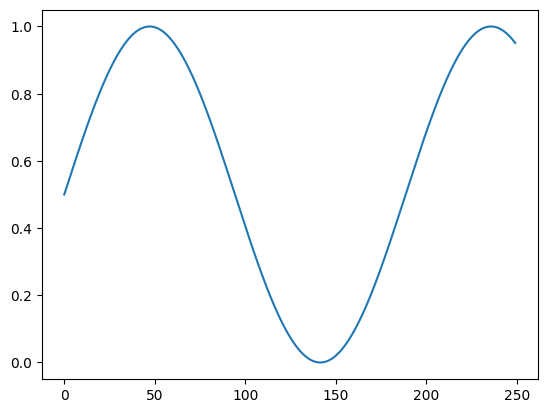

In [ ]:
# Отобразим сгенерированные данные внутри среды
plt.figure()
plt.plot(environment.data)
plt.show()

In [ ]:
for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, DATASET_LENGTH - REWARD_TIME, REWARD_TIME):
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Получаем текущее состояние. Производные в отдельном интервале
        # Текущий Y на графике и предыдущие WINDOW_SHAPE шагов
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # Получаем предсказание по данному состоянию через модель
        q_value_j = agent.get_value_action_value(state_j)

        # 2. Выбираем действие для текущего состояния
        # В зависимости от длины эпсилона, выбираем случайное действие
        # или реальные по предсказаниям
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = np.argmax(q_value_j.detach().numpy())

        # 3. Получаем награду за выбранное действие
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. Получаем будущее состояние. Производные в будущем интервале
        # Текущий Y + 1 на графике и предыдущие WINDOW_SHAPE шагов
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. Сохраняем все полученные данные в агента
        agent.save_experience(state_j, action, reward_value_j, state_j_1)

        # 6. Как только число ранее полученных сэмплов перевалило
        # за необходимое, начинаем тренировать сеть
        if j > SAMPLE_SIZE * 2:
            agent.replay_experience(gamma, SAMPLE_SIZE)

    # С каждым шагом уменьшаем эпсилон, чтобы бот начинал действовать
    # по собственным прогнозам и переставал изучать среду
    if epsilon > 0.1:
        epsilon -= 1.0 / epochs

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

Epoch 0 ... -7.377049180327869
Epoch 1 ... 5.737704918032787
Epoch 2 ... -6.557377049180328
Epoch 3 ... -9.01639344262295
Epoch 4 ... -5.737704918032787
Epoch 5 ... -3.278688524590164
Epoch 6 ... 3.278688524590164
Epoch 7 ... 4.918032786885246
Epoch 8 ... 49.18032786885246
Epoch 9 ... 40.16393442622951
Epoch 10 ... 51.63934426229508
Epoch 11 ... 46.721311475409834
Epoch 12 ... 44.26229508196721
Epoch 13 ... 54.91803278688525
Epoch 14 ... 61.47540983606557
Epoch 15 ... 59.01639344262295
Epoch 16 ... 75.40983606557377
Epoch 17 ... 84.42622950819673
Epoch 18 ... 83.60655737704919
Epoch 19 ... 80.32786885245902


In [ ]:
action_to_backtest_action = {
    1: 1,  # покупаем
    0: -1,  # продаем
}

## Sine

In [ ]:
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME):
    # Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment.get_state(j, WINDOW_SHAPE)
    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j)
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

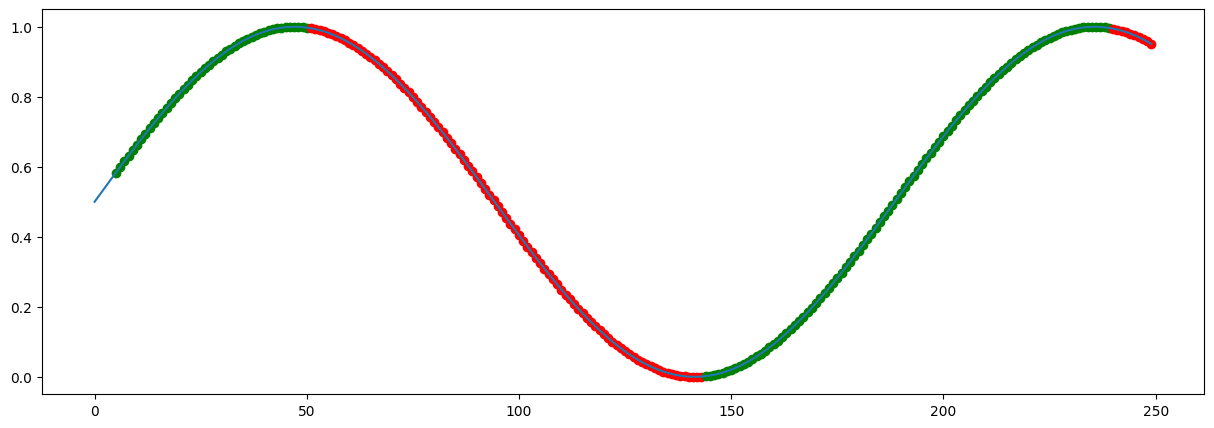

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(environment.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data[e], color = 'red')
    else:
        pass
plt.show()

<Axes: >

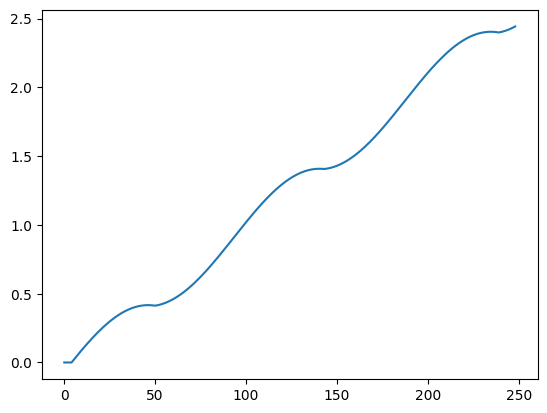

In [ ]:
# Составляем график доходов. Сделаем фрейм формата Цена/Сигнал
backtest = pd.DataFrame({
    'price': environment.data.flatten(),
    # Первые 5 сигналов отсутствуют, мы должны расширить данные
    # и добавить дополнительные 5 элементов в начало с сигналом 0
    'signal': [0] * WINDOW_SHAPE + actions
})
# Получаем производные цен и делаем сдвиг
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# Суммируем доходы и выводим график
(backtest['price_diff'] * backtest['signal']).cumsum().plot()

Идеально!

## Sine with different frequencies

Let's complicate our agent's life by summing up 4 cosine functions with different frequency periods and try to trade on these combined waves.

The result is still excellent — our representation of the market clearly reflects trends, and even if our model was trained on a different type of data, it still knows what to do with another wave.

In [ ]:
data_new = pd.DataFrame(
    np.cos(np.arange(DATASET_LENGTH)/5.0) +
    np.cos(np.arange(DATASET_LENGTH)/10) +
    np.cos(np.arange(DATASET_LENGTH)/20) +
    np.cos(np.arange(DATASET_LENGTH)/30)
    )
print(data_new)

            0
0    4.000000
1    3.973265
2    3.893910
3    3.764447
4    3.588959
..        ...
245  1.749758
246  1.971078
247  2.162457
248  2.316891
249  2.428503

[250 rows x 1 columns]


In [ ]:
environment3 = Environment(DATASET_LENGTH, True, True, data_new)
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME):
    # Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment3.get_state(j, WINDOW_SHAPE)
    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j)
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

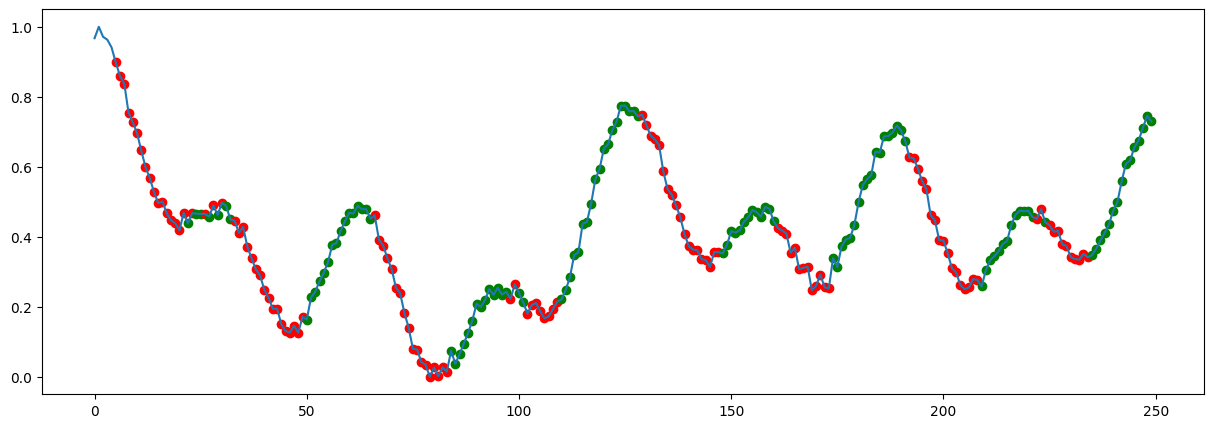

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(environment3.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment3.data[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment3.data[e], color = 'red')
    else:
        pass
plt.show()

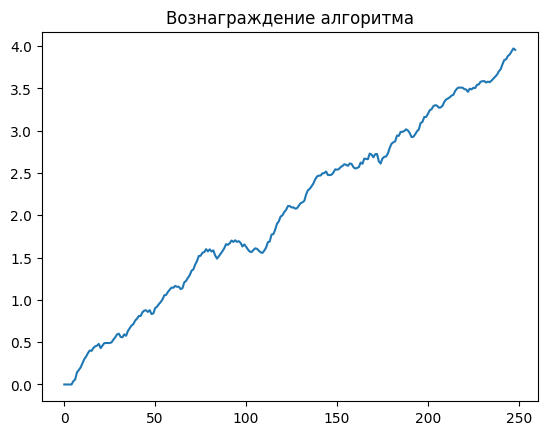

In [ ]:
# Составляем график доходов. Сделаем фрейм формата Цена/Сигнал
backtest = pd.DataFrame({
    'price': environment3.data.flatten(),
    # Первые 5 сигналов отсутствуют, мы должны расширить данные
    # и добавить дополнительные 5 элементов в начало с сигналом 0
    'signal': [0] * WINDOW_SHAPE + actions
})
# Получаем производные цен и делаем сдвиг
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# Суммируем доходы и выводим график
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Вознаграждение алгоритма')
plt.show()

And again, perfect :)

## Noisy sine wave

Now let's complicate the exercise a bit and `add Gaussian noise` to the time series without retraining the model.

The algorithm works worse, but it earns some profit! Now there are some confusing points, but on average the model still learns where the long-term trends of our noisy cosine function are.

In [ ]:
environment2 = Environment(DATASET_LENGTH, True, True)
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME):
    # Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment2.get_state(j, WINDOW_SHAPE)
    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j)
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

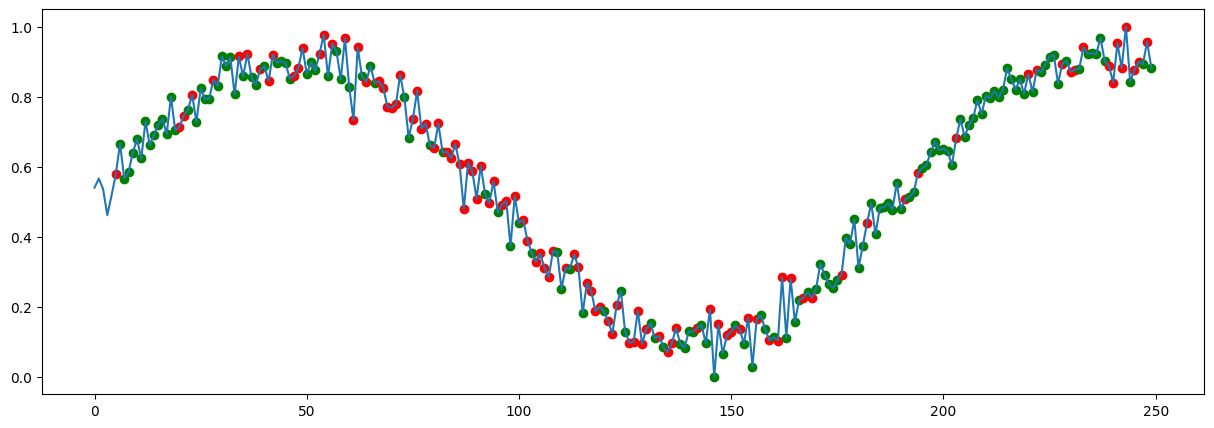

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(environment2.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment2.data[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment2.data[e], color = 'red')
    else:
        pass
plt.show()

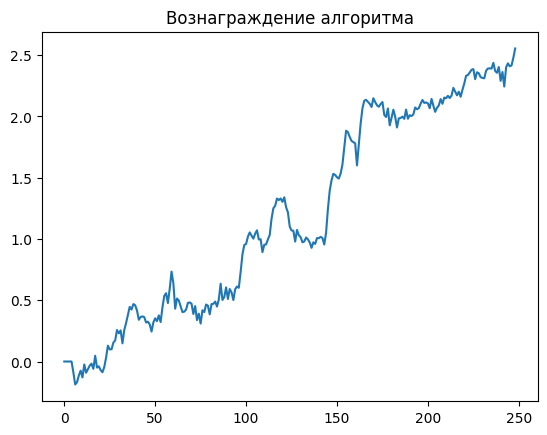

In [ ]:
# Составляем график доходов. Сделаем фрейм формата Цена/Сигнал
backtest = pd.DataFrame({
    'price': environment2.data.flatten(),
    # Первые 5 сигналов отсутствуют, мы должны расширить данные
    # и добавить дополнительные 5 элементов в начало с сигналом 0
    'signal': [0] * WINDOW_SHAPE + actions
})
# Получаем производные цен и делаем сдвиг
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# Суммируем доходы и выводим график
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Вознаграждение алгоритма')
plt.show()

It's not great, but believe me, by choosing hyperparameters, you can achieve the same excellent result here as in the previous examples.

# Checking the algorithm on real data (Tesla shares)

It remains to see if we can enrich ourselves by applying the same neural network to real stock quotes.:

In [ ]:
!pip install yfinance
clear_output()
import yfinance as yf

In [ ]:
df = yf.download(tickers='TSLA')
df = df[-500:]
df = df.reset_index(drop=True)
print(df.head())

[*********************100%%**********************]  1 of 1 completed

         Open        High         Low       Close   Adj Close    Volume
0  282.829987  287.739990  280.700012  284.820007  284.820007  41864700
1  287.869995  288.480011  272.649994  277.700012  277.700012  50541800
2  280.619995  281.250000  271.809998  275.609985  275.609985  52107300
3  272.579987  277.579987  266.149994  277.160004  277.160004  54287000
4  281.070007  282.350006  269.079987  270.209991  270.209991  50890100


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    y = df['Close'][:],
    line =  dict(shape =  'spline' ),
    name = 'Курс акции TSLA'
            ))
fig.show()

In [ ]:
df['Close']

,Close
0,284.820007
1,277.700012
2,275.609985
3,277.160004
4,270.209991
...,...
495,222.720001
496,221.100006
497,223.270004
498,210.660004


In [ ]:
# Прописываем новую среду и передаем данные о закрытии цены
environment4 = Environment(len(df['Close']), False, False, df['Close'])
actions = []

for j in range(WINDOW_SHAPE, len(df['Close']), REWARD_TIME):
    # 1. Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment4.get_state(j, WINDOW_SHAPE)

    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j)
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

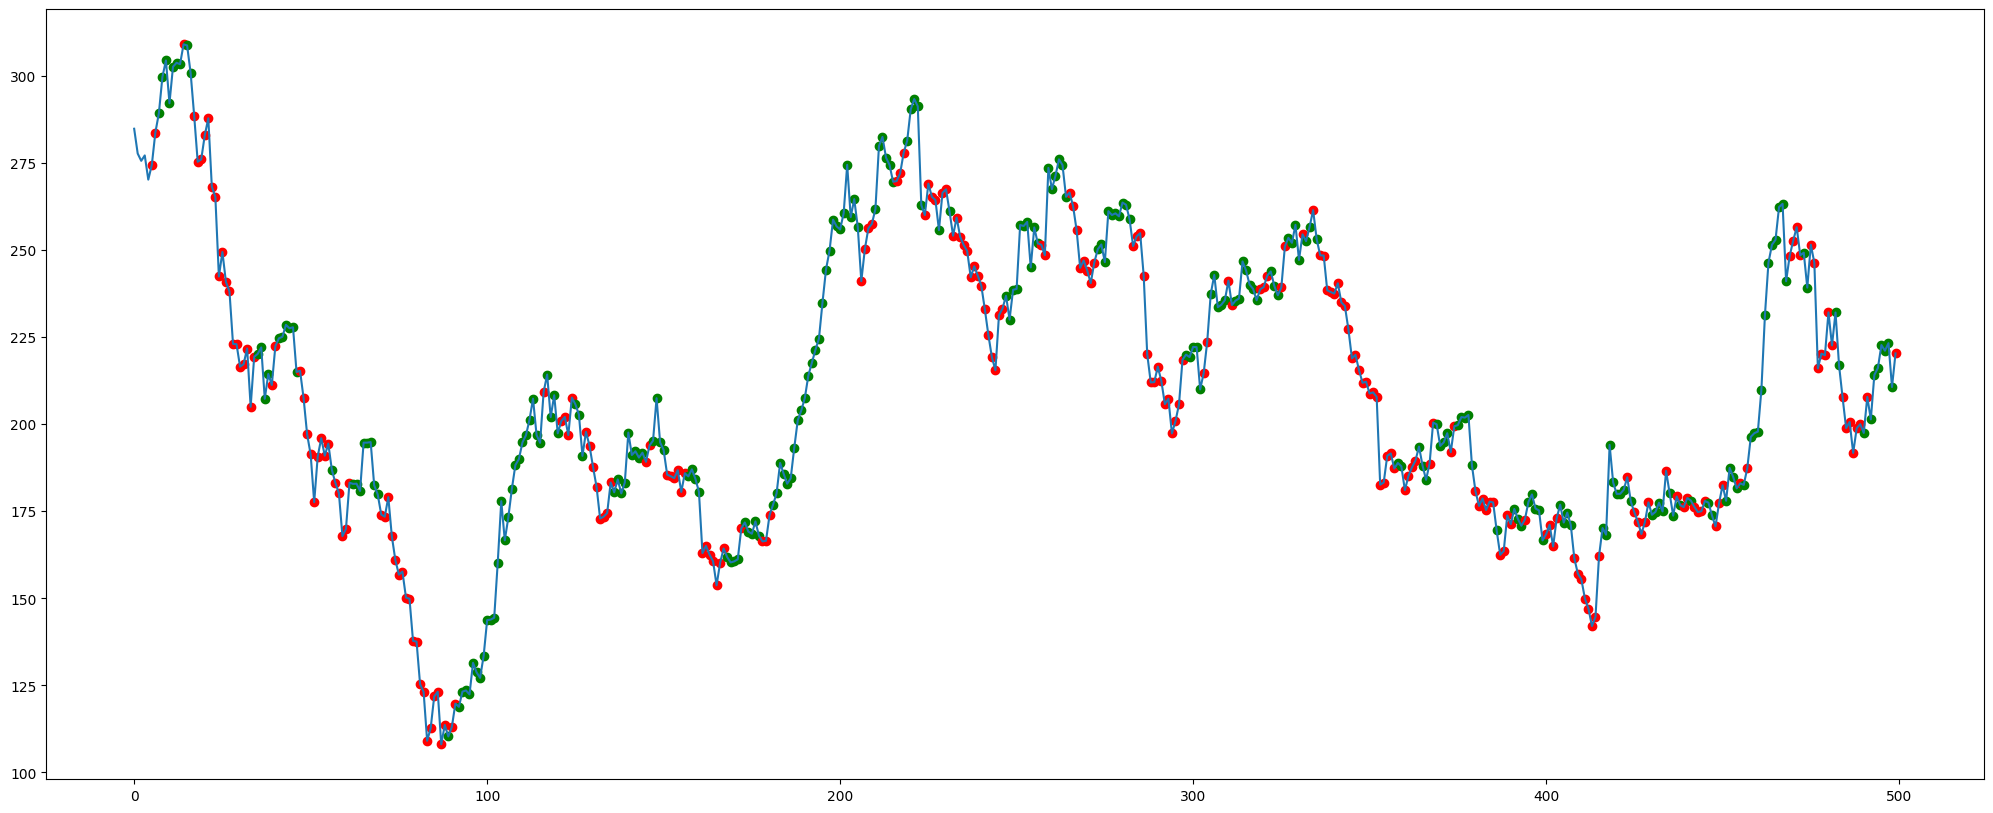

In [ ]:
plt.figure(figsize = (25, 10))
plt.plot(environment4.data)
for e, a in enumerate(actions):
    print(f"{e} {a}", end='\r')
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment4.data[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment4.data[e], color = 'red')
    else:
        pass
plt.show()

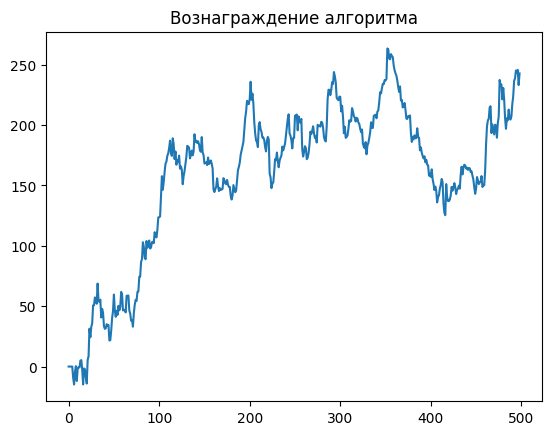

In [ ]:
 # Составляем график доходов. Сделаем фрейм формата Цена/Сигнал
backtest = pd.DataFrame({
    'price': environment4.data.flatten(),
    # Первые 5 сигналов отсутствуют, мы должны расширить данные
    # и добавить дополнительные 5 элементов в начало с сигналом 0
    'signal': [0] * WINDOW_SHAPE + actions
})
# Получаем производные цен и делаем сдвиг
backtest['price_diff'] = backtest['price'].diff().shift(-1)
# Суммируем доходы и выводим график
(backtest['price_diff'] * backtest['signal']).cumsum().plot()
plt.title('Вознаграждение алгоритма')
plt.show()

## Why can't we get a stable result all of a sudden?

**Response:** the strong non-stationarity of the time series and the fact that our Agent studied in an Environment very different from the Environment he had to face.

In real life, stock quotes are almost random in nature: the average, variance and frequency of changes change. Therefore, our neural network `catches` only special cases of `market imperfections` and, at such moments, the algorithm increases its reward. And the rest of the time, he loses it..

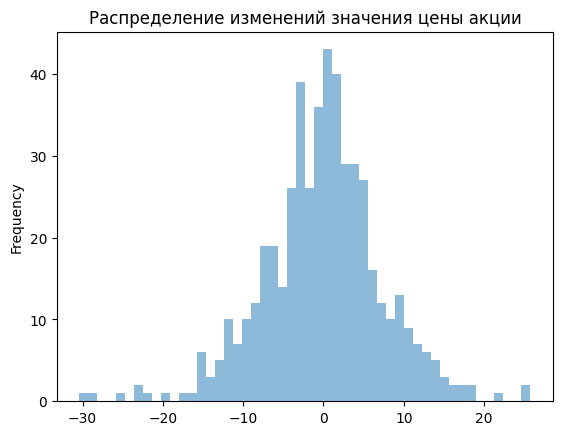

In [ ]:
df['Close'].diff(1).plot.hist(bins=50, alpha=0.5)
plt.title('Распределение изменений значения цены акции')
plt.show()



Precisely because real life is very diverse and short-term price movements are random, there is little benefit in learning RL based on refined (simplified) models offered by various artificial environments).

It is necessary to learn to describe the environment independently, to reward agents. Only then will you realize how delicate this task is, requiring an understanding of the relationship of real factors with each other and with the actions of the agent.

# Renferences:

1. [Reinforcement Learning: An Introduction. Richard S. Sutton and Andrew G. Barto 2014, 2015](https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf)
2. [Advances in Financial Machine Learning](https://www.amazon.com/Advances-Financial-Machine-Learning-Marcos/dp/1119482089)
3. [Trend following](https://en.wikipedia.org/wiki/Trend_following)
4. [Links to Algorithms in Taxonomy](https://spinningup.openai.com/en/latest/spinningup/rl_intro2.html#links-to-algorithms-in-taxonomy)

####Change the reward function so that it does not give exactly +1 or -1 depending on the predicted result, but is proportional to the prediction error.

In [ ]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет
        происходить дальнейшее обучение
    '''
    def __init__(self, length = 100, normalize = True, noise = True, data = []):
        self.length = length

        if len(data) == 0:
            # Если данные не поданы, формируем их сами
            # на основе синуса размером length
            self.data = np.sin(np.arange(length) / 30.0)
        else:
            # Иначе подугружаем существующие
            self.data = data.values.flatten()


        if noise:
            # Подаем шум для данных от 0.1 до 1
            self.data += np.random.normal(0, 0.1, size = self.data.shape)

        if normalize:
            # Нормализация после данных после шума
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        Возвращаем производные отдельного окна в нашей выборке
        и убираем нули в начале
        """
        window = self.data[time-lookback:time]
        if diff: window = np.diff(window, prepend = window.flatten()[0])
        return window

    def get_reward(self, action, action_time, reward_time, coef = 100):
        """
        Основная логика получения награды
        0 => long 1 => hold 2 => short
        """
        if action == 0:
            action = -1
        # print(23, self.data)
        # Вытаскиваем текущую цену
        price_now = self.data[action_time]
        # Вытаскиваем следующую цену
        price_reward = self.data[reward_time]
        # Получаем разницу (теперь уже не в проценте, чтобы не делить на ноль)
        price_diff = (price_reward - price_now)

        #ИЗМЕНЕНИЕ ТУТ!!!
        #Убераем np.sign()
        reward = price_diff * action * coef
        # print(12121, reward)
        return reward

In [ ]:
environment = Environment(DATASET_LENGTH, True, False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE) #Создаем агента

In [ ]:
for i in range(epochs):
    learning_progress = []
    for j in range(WINDOW_SHAPE, DATASET_LENGTH - REWARD_TIME, REWARD_TIME):
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Получаем текущее состояние. Производные в отдельном интервале
        # Текущий Y на графике и предыдущие WINDOW_SHAPE шагов
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # Получаем предсказание по данному состоянию через модель
        q_value_j = agent.get_value_action_value(state_j)

        # 2. Выбираем действие для текущего состояния
        # В зависимости от длины эпсилона, выбираем случайное действие
        # или реальные по предсказаниям
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = np.argmax(q_value_j.detach().numpy())

        # 3. Получаем награду за выбранное действие
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. Получаем будущее состояние. Производные в будущем интервале
        # Текущий Y + 1 на графике и предыдущие WINDOW_SHAPE шагов
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. Сохраняем все полученные данные в агента
        agent.save_experience(state_j, action, reward_value_j, state_j_1)

        # 6. Как только число ранее полученных сэмплов перевалило
        # за необходимое, начинаем тренировать сеть
        if j > SAMPLE_SIZE * 2:
            agent.replay_experience(gamma, SAMPLE_SIZE)

    # С каждым шагом уменьшаем эпсилон, чтобы бот начинал действовать
    # по собственным прогнозам и переставал изучать среду
    if epsilon > 0.1:
        epsilon -= 1.0 / epochs

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

Epoch 0 ... -0.15445435750562578
Epoch 1 ... -0.15114650471819835
Epoch 2 ... -0.12752475381472084
Epoch 3 ... -0.14555470370064164
Epoch 4 ... -0.1389196583336714
Epoch 5 ... -0.13610609639897325
Epoch 6 ... 0.008514375220013833
Epoch 7 ... -0.33362760538328406
Epoch 8 ... 0.8526030398421532
Epoch 9 ... 0.6801139494937816
Epoch 10 ... 0.7723856723676408
Epoch 11 ... 0.7617807503566643
Epoch 12 ... 0.7874602452792061
Epoch 13 ... 0.8750593957236579
Epoch 14 ... 0.771509506162299
Epoch 15 ... 0.7487695775474212
Epoch 16 ... 0.6713171497751433
Epoch 17 ... 0.7504230293201145
Epoch 18 ... 0.8367462776505523
Epoch 19 ... 0.8451923101055654


In [ ]:
actions = []
for j in range(WINDOW_SHAPE, DATASET_LENGTH, REWARD_TIME):
    # Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment.get_state(j, WINDOW_SHAPE)
    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j)
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

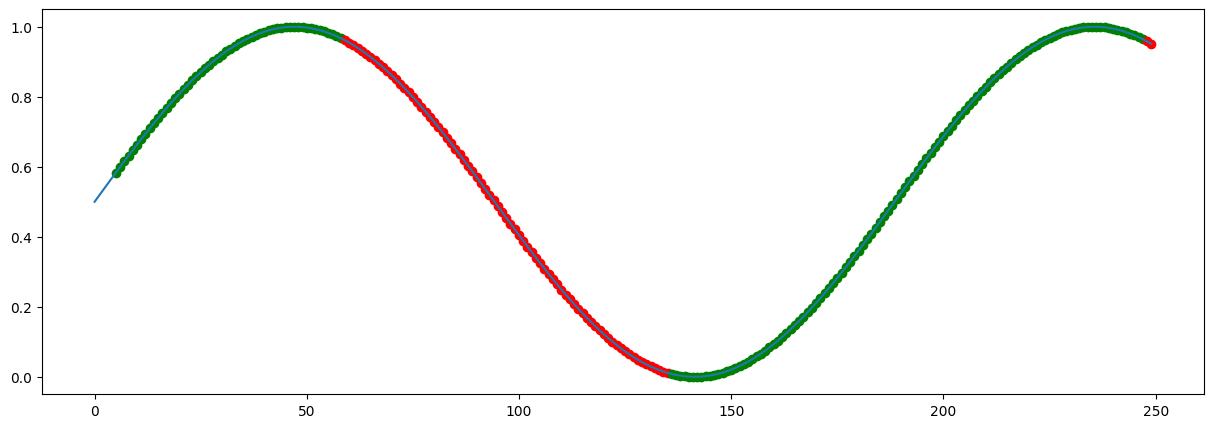

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(environment.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data[e], color = 'red')
    else:
        pass
plt.show()

The results were good - about the same as with a reward of +1 or -1.

## Try to train a neural network on a sine wave with one frequency, but then apply it to a sine wave with a different frequency

In [ ]:
class Environment:
    '''
        Рабочая среда робота, внутри которого будет
        происходить дальнейшее обучение
    '''
    def __init__(self, train_data, test_data, normalize = True, noise = True):
        self.train_length = train_data.shape[0]
        self.test_length = test_data.shape[0]
        self.data = np.concatenate([train_data.flatten(), test_data.flatten()])


        if noise:
            # Подаем шум для данных от 0.1 до 1
            self.data += np.random.normal(0, 0.1, size = self.data.shape)
        if normalize:
            # Нормализация после данных после шума
            self.data = (self.data - self.data.min()) / (self.data.max() - self.data.min())

    def get_state(self, time, lookback, diff = True):
        """
        Возвращаем производные отдельного окна в нашей выборке
        и убираем нули в начале
        """
        window = self.data[time-lookback:time]
        if diff: window = np.diff(window, prepend = window.flatten()[0])
        return window

    def get_reward(self, action, action_time, reward_time, coef = 100):
        """
        Основная логика получения награды
        0 => long 1 => hold 2 => short
        """
        if action == 0:
            action = -1
        # print(23, self.data)
        # Вытаскиваем текущую цену
        price_now = self.data[action_time]
        # Вытаскиваем следующую цену
        price_reward = self.data[reward_time]
        # Получаем разницу в проценте
        price_diff = (price_reward - price_now) / price_now
        # Прибавляем к портфелю следующее число:
        # Дельта изменения валюты * покупку/продажу/холд * коэф. закупки
        reward = np.sign(price_diff) * action * coef
        # print(12121, reward)
        return reward

In [ ]:
def create_cosine(num_elements = 500, num_periods = 1, trend = 0):
    return np.cos(np.linspace(0, num_periods * 2 * np.math.pi, num_elements)) + trend * np.linspace(0, num_periods * 2 * np.math.pi, num_elements)

In [ ]:
train_dataset = create_cosine(num_periods = 3, trend = 0.2)
test_dataset = create_cosine(num_periods = 2, trend = -0.2)

environment = Environment(train_dataset, test_dataset, normalize = True, noise = False)
agent = BuyHoldSellAgent(WINDOW_SHAPE, ACTIONS_SHAPE)

In [ ]:
epsilon = 0.95

for i in range(epochs):

    learning_progress = []
    for j in range(WINDOW_SHAPE, environment.train_length - REWARD_TIME, REWARD_TIME):
        print(f"{i} / {epochs} : {j} {DATASET_LENGTH - REWARD_TIME}", end='\r')

        # 1. Получаем текущее состояние. Производные в отдельном интервале
        # Текущий Y на графике и предыдущие WINDOW_SHAPE шагов
        state_j = environment.get_state(j, WINDOW_SHAPE)
        # Получаем предсказание по данному состоянию через модель
        q_value_j = agent.get_value_action_value(state_j)

        # 2. Выбираем действие для текущего состояния
        # В зависимости от длины эпсилона, выбираем случайное действие
        # или реальные по предсказаниям
        if (np.random.random() < epsilon):
            action = np.random.randint(0, ACTIONS_SHAPE)
        else:
            action = np.argmax(q_value_j.detach().numpy())

        # 3. Получаем награду за выбранное действие
        reward_value_j = environment.get_reward(action, j, j + REWARD_TIME)
        learning_progress.append(reward_value_j)

        # 4. Получаем будущее состояние. Производные в будущем интервале
        # Текущий Y + 1 на графике и предыдущие WINDOW_SHAPE шагов
        state_j_1 = environment.get_state(j + 1, WINDOW_SHAPE)

        # 5. Сохраняем все полученные данные в агента
        agent.save_experience(state_j, action, reward_value_j, state_j_1)

        # 6. Как только число ранее полученных сэмплов перевалило
        # за необходимое, начинаем тренировать сеть
        if j > SAMPLE_SIZE * 2:
            agent.replay_experience(gamma, SAMPLE_SIZE)

    # С каждым шагом уменьшаем эпсилон, чтобы бот начинал действовать
    # по собственным прогнозам и переставал изучать среду
    if epsilon > 0.1:
        epsilon -= 1.0 / epochs

    print('Epoch', i, '...', np.mean(learning_progress))
    learning_progress = []

Epoch 0 ... -5.668016194331984
Epoch 1 ... -2.42914979757085
Epoch 2 ... -2.42914979757085
Epoch 3 ... -0.4048582995951417
Epoch 4 ... 10.526315789473685
Epoch 5 ... 6.882591093117409
Epoch 6 ... -3.2388663967611335
Epoch 7 ... 8.906882591093117
Epoch 8 ... 4.8582995951417
Epoch 9 ... 2.834008097165992
Epoch 10 ... 3.6437246963562755
Epoch 11 ... 8.502024291497976
Epoch 12 ... 5.2631578947368425
Epoch 13 ... 4.4534412955465585
Epoch 14 ... 11.336032388663968
Epoch 15 ... 3.6437246963562755
Epoch 16 ... 10.526315789473685
Epoch 17 ... 9.7165991902834
Epoch 18 ... 9.7165991902834
Epoch 19 ... 10.526315789473685


In [ ]:
actions = []
for j in range(WINDOW_SHAPE, environment.train_length + environment.test_length - REWARD_TIME, REWARD_TIME):
    # Получаем производные в отдельном интервале
    # Текущая цена и предыдущие WINDOW_SHAPE шагов
    state_j = environment.get_state(j, WINDOW_SHAPE)
    # Получаем предикт бота по данным
    q_value_j = agent.get_value_action_value(state_j.reshape(1,WINDOW_SHAPE))
    # Определяем сигнал и записываем в события
    actions.append(action_to_backtest_action[np.argmax(q_value_j.detach().numpy())])

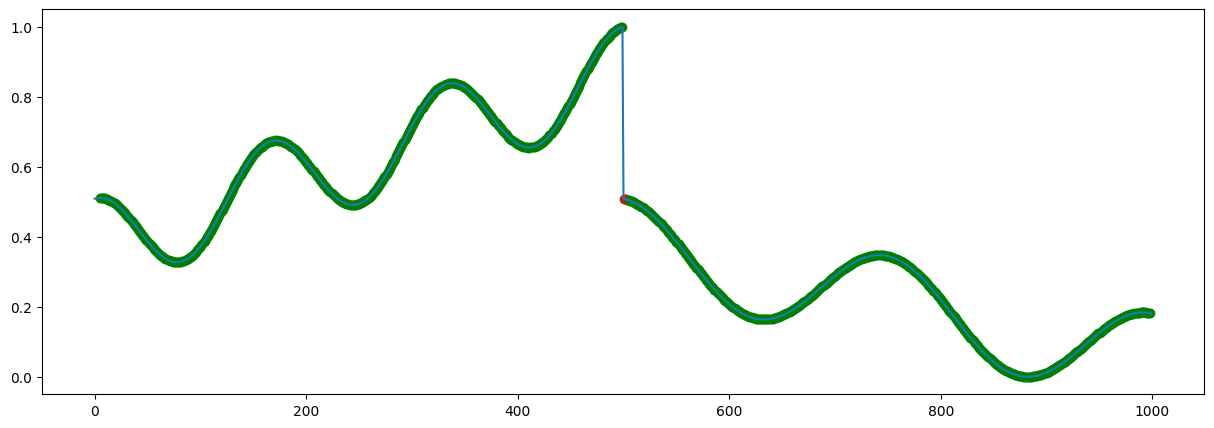

In [ ]:
plt.figure(figsize = (15, 5))
plt.plot(environment.data)
for e, a in enumerate(actions):
    e += WINDOW_SHAPE
    if a == 1:
        plt.scatter(e, environment.data[e], color = 'green')
    elif a == -1:
        plt.scatter(e, environment.data[e], color = 'red')
    else:
        pass
plt.show()

As we can see, a neural network begins to get confused if the data on which it is being tested differs from the data from the training sample (for example, they have different frequencies).


## Materials:
https://github.com/ikonushok/AI-Traiding
